# Spatial Analysis

In [1]:
# to read and wrangle data
import pandas as pd
import numpy as np

# to import data from LA Data portal
from sodapy import Socrata

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

import folium

In [2]:
df = pd.read_csv('data/Main Data - main (1).csv')
censusdata = gpd.read_file('data/Census_Tracts_2020.geojson')

In [3]:
censusdata['tract']='06' + '037' + censusdata ['CT20']

In [4]:
df.columns = ['Unnamed: 0', 'ignore', 'tract', 'sup_dist', 'csa', 'spa',
       'ESRI_OID', 'Shape__Area', 'Shape__Length', 'Total Woman 15-50',
       'Women with births 12 Months', 'Total Population', 'Birth Rate',
       'Fertility Rate', 'Low Birth Weight', 'Low Birth Weight Pctl',
       'Average income', 'Grocery Store Access',
       'Grocery Store Access Percent','CalFresh Cases','CF cases per 100']
df.columns

Index(['Unnamed: 0', 'ignore', 'tract', 'sup_dist', 'csa', 'spa', 'ESRI_OID',
       'Shape__Area', 'Shape__Length', 'Total Woman 15-50',
       'Women with births 12 Months', 'Total Population', 'Birth Rate',
       'Fertility Rate', 'Low Birth Weight', 'Low Birth Weight Pctl',
       'Average income', 'Grocery Store Access',
       'Grocery Store Access Percent', 'CalFresh Cases', 'CF cases per 100'],
      dtype='object')

In [5]:
df['census tract']='0'+ df['tract'].apply(str)

In [6]:
df.head()

,Unnamed: 0,ignore,tract,sup_dist,csa,spa,ESRI_OID,Shape__Area,Shape__Length,Total Woman 15-50,...,Birth Rate,Fertility Rate,Low Birth Weight,Low Birth Weight Pctl,Average income,Grocery Store Access,Grocery Store Access Percent,CalFresh Cases,CF cases per 100,census tract
0,0,6037199700,6037199700,District 1,Los Angeles - Wholesale District,SPA 4 - Metro,2347,1.041050e+07,13808.463240,678,...,0.006779,0.033923,6.52,83.85,38892.0,0.0,0.0,301.0,43.8,06037199700
1,0,6037199801,6037199801,District 1,Los Angeles - Lincoln Heights,SPA 4 - Metro,2348,3.724107e+06,9459.391827,911,...,0.027997,0.093304,0.00,0.00,41027.0,0.0,0.0,286.0,36.2,06037199801
2,0,6037199802,6037199802,District 1,Los Angeles - Lincoln Heights,SPA 4 - Metro,2349,3.296129e+06,8868.744225,458,...,0.006996,0.032751,0.00,0.00,42500.0,0.0,0.0,242.0,49.1,06037199802
3,0,6037199900,6037199900,District 1,Los Angeles - Lincoln Heights,SPA 4 - Metro,2350,4.782361e+06,10141.728020,573,...,0.003786,0.017452,5.43,62.88,37232.0,0.0,0.0,264.0,50.7,06037199900
4,0,6037201110,6037201110,District 1,Los Angeles - El Sereno,SPA 4 - Metro,2351,1.099246e+07,15893.383640,715,...,0.015866,0.051748,7.08,90.67,65000.0,0.0,0.0,136.0,26.0,06037201110


In [7]:
censusdata.head()

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,tract
0,1,101110,1011.10,1.229562e+07,15083.854287,"POLYGON ((-118.28491 34.25948, -118.28492 34.2...",06037101110
1,2,101122,1011.22,2.845774e+07,31671.455844,"POLYGON ((-118.29015 34.27417, -118.29015 34.2...",06037101122
2,3,101220,1012.20,7.522093e+06,12698.783810,"POLYGON ((-118.28100 34.25592, -118.28198 34.2...",06037101220
3,4,101221,1012.21,3.812000e+06,9161.710543,"POLYGON ((-118.28735 34.25591, -118.28863 34.2...",06037101221
4,5,101222,1012.22,3.191371e+06,9980.600461,"POLYGON ((-118.28594 34.25405, -118.28594 34.2...",06037101222


In [8]:
censusdata['census tract']='06' + '037' + censusdata ['CT20']

In [9]:
LBW=censusdata.merge(df,on="census tract")

In [10]:
SPA=gpd.read_file('data/Service_Planning_Areas_2022_(view).geojson')

In [11]:
selected_SPAs = SPA[SPA['LABEL'].isin(['SPA 4','SPA 5'])]

In [12]:
our_SPA=gpd.GeoDataFrame(selected_SPAs)

In [13]:
SNAP= pd.read_csv('data/SNAP_Retailer_Location_data.csv')

In [14]:
SNAP.shape

(8132, 17)

In [15]:
SNAP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8132 entries, 0 to 8131
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   X                     8132 non-null   float64
 1   Y                     8132 non-null   float64
 2   Record_ID             8132 non-null   int64  
 3   Store_Name            8132 non-null   object 
 4   Store_Street_Address  8132 non-null   object 
 5   Additonal_Address     746 non-null    object 
 6   City                  8132 non-null   object 
 7   State                 8132 non-null   object 
 8   Zip_Code              8132 non-null   int64  
 9   Zip4                  8132 non-null   object 
 10  County                8132 non-null   object 
 11  Store_Type            8132 non-null   object 
 12  Latitude              8132 non-null   float64
 13  Longitude             8132 non-null   float64
 14  Incentive_Program     89 non-null     object 
 15  Grantee_Name         

In [16]:
SNAP = gpd.GeoDataFrame(SNAP, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(SNAP.X, SNAP.Y))

In [17]:
SNAP_clip = gpd.clip(SNAP, our_SPA)

In [18]:
SNAP_clip = SNAP_clip.to_crs(epsg=3857)

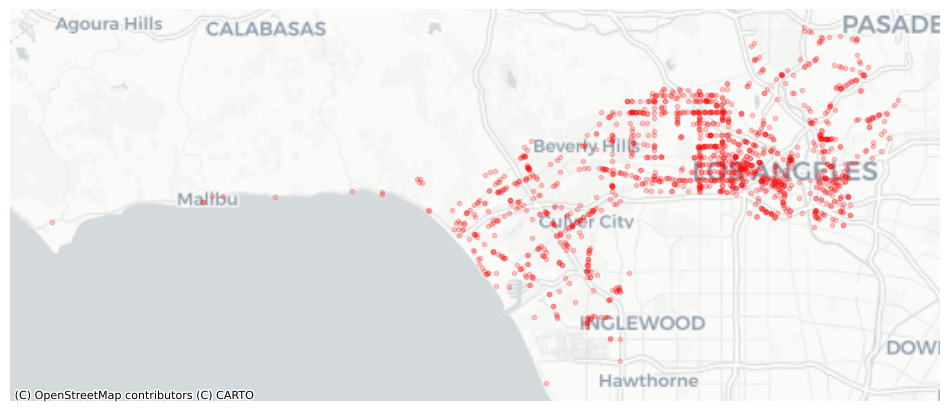

In [19]:
fig,ax = plt.subplots(figsize=(12,12))

SNAP_clip.plot(ax=ax,
             color='red',
             markersize=10,
              alpha=0.2)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [20]:
minx, miny, maxx, maxy = SNAP_clip.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-13225808.588623803
-13153034.58471261
4017685.127765333
4048354.4142391556


In [21]:
LBW.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   OBJECTID                      537 non-null    int64   
 1   CT20                          537 non-null    object  
 2   LABEL                         537 non-null    object  
 3   ShapeSTArea                   537 non-null    float64 
 4   ShapeSTLength                 537 non-null    float64 
 5   geometry                      537 non-null    geometry
 6   tract_x                       537 non-null    object  
 7   census tract                  537 non-null    object  
 8   Unnamed: 0                    537 non-null    int64   
 9   ignore                        537 non-null    int64   
 10  tract_y                       537 non-null    int64   
 11  sup_dist                      537 non-null    object  
 12  csa                           537 non-null

In [22]:
LBW = LBW.to_crs(epsg=3857)

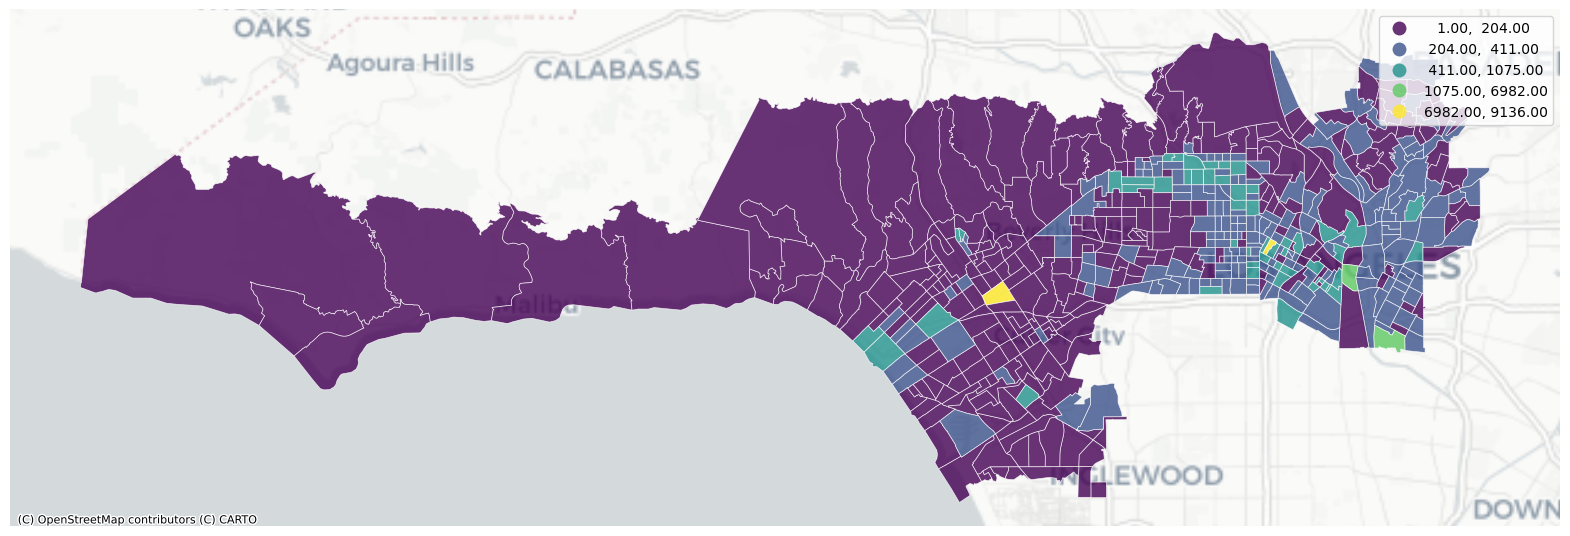

In [23]:

# plot it!
fig, ax = plt.subplots(figsize=(20,20))

LBW.plot(ax=ax,
         column='CalFresh Cases',
         scheme='naturalbreaks', 
         edgecolor='white',
         legend=True,
         lw=0.5,
         alpha=0.8)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

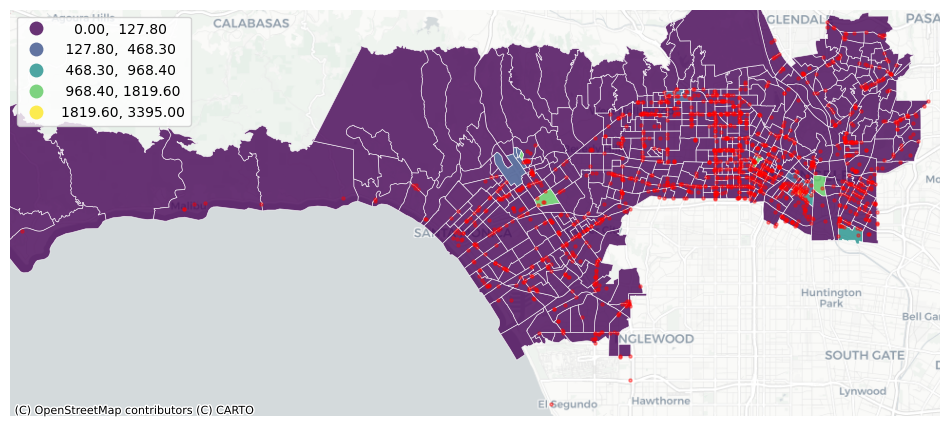

In [24]:
# plot it!
fig, ax = plt.subplots(figsize=(12,12))

LBW.plot(ax=ax,
         column='CF cases per 100', 
         scheme='naturalbreaks',
         edgecolor='white',
         legend=True,
         lw=0.5,
         alpha=0.8)

SNAP_clip.plot(ax=ax, # this also puts it in the same ax plot
        color='red',
        markersize=5,
        alpha=0.4)

ax.set_xlim(minx - 1000, maxx + 1000) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - 1000, maxy + 1000)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [25]:
join = gpd.sjoin(LBW, SNAP_clip, how='left')

In [26]:
join.shape

(1503, 47)

In [27]:
join.columns

Index(['OBJECTID', 'CT20', 'LABEL', 'ShapeSTArea', 'ShapeSTLength', 'geometry',
       'tract_x', 'census tract', 'Unnamed: 0', 'ignore', 'tract_y',
       'sup_dist', 'csa', 'spa', 'ESRI_OID', 'Shape__Area', 'Shape__Length',
       'Total Woman 15-50', 'Women with births 12 Months', 'Total Population',
       'Birth Rate', 'Fertility Rate', 'Low Birth Weight',
       'Low Birth Weight Pctl', 'Average income', 'Grocery Store Access',
       'Grocery Store Access Percent', 'CalFresh Cases', 'CF cases per 100',
       'index_right', 'X', 'Y', 'Record_ID', 'Store_Name',
       'Store_Street_Address', 'Additonal_Address', 'City', 'State',
       'Zip_Code', 'Zip4', 'County', 'Store_Type', 'Latitude', 'Longitude',
       'Incentive_Program', 'Grantee_Name', 'ObjectId'],
      dtype='object')

In [28]:
join.columns =['OBJECTID', 'CT20', 'LABEL', 'ShapeSTArea', 'ShapeSTLength', 'geometry',
       'tract_x', 'census_tract', 'Unnamed: 0', 'ignore', 'tract_y',
       'sup_dist', 'csa', 'spa', 'ESRI_OID', 'Shape__Area', 'Shape__Length',
       'Total Woman 15-50', 'Women with births 12 Months', 'Total Population',
       'Birth Rate', 'Fertility Rate', 'Low Birth Weight',
       'Low Birth Weight Pctl', 'Average income', 'Grocery Store Access',
       'Grocery Store Access Percent', 'CalFresh Cases', 'CF cases per 100',
       'index_right', 'X', 'Y', 'Record_ID', 'Store_Name',
       'Store_Street_Address', 'Additonal_Address', 'City', 'State',
       'Zip_Code', 'Zip4', 'County', 'Store_Type', 'Latitude', 'Longitude',
       'Incentive_Program', 'Grantee_Name', 'ObjectId']

In [29]:
SNAP_by_tract = join.census_tract.value_counts().rename_axis('census_tract').reset_index(name='SNAP_count')


<Axes: xlabel='census_tract'>

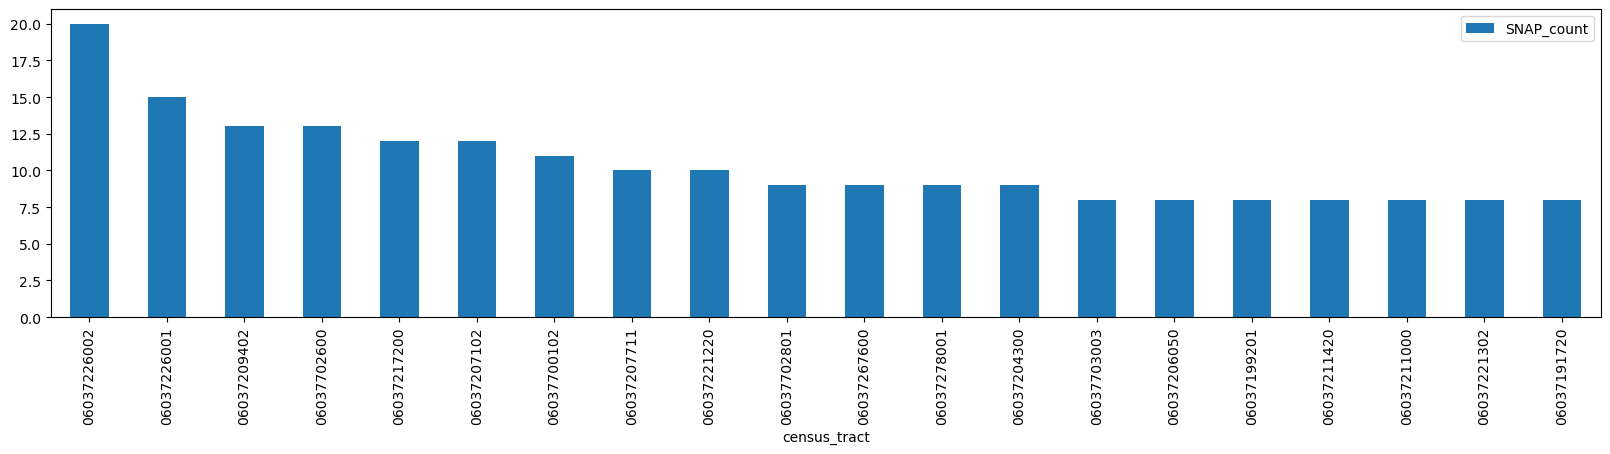

In [30]:
SNAP_by_tract[:20].plot.bar(figsize=(20,4),
                             x='census_tract',
                             y='SNAP_count')

<Axes: ylabel='Frequency'>

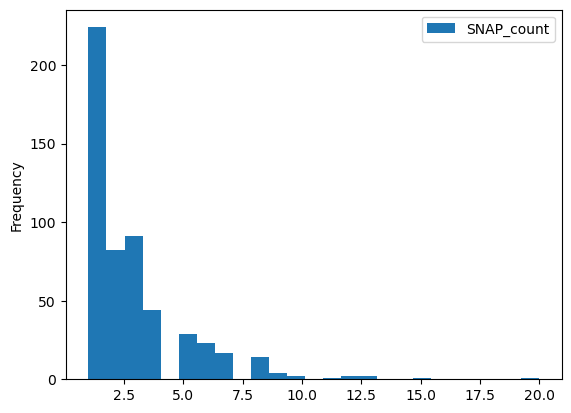

In [31]:
SNAP_by_tract.plot.hist(bins=25)

{'whiskers': [<matplotlib.lines.Line2D at 0x7ddc4b536050>,
 'caps': [<matplotlib.lines.Line2D at 0x7ddc4b537490>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ddc4b535750>],
 'medians': [<matplotlib.lines.Line2D at 0x7ddc4b540510>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ddc4b540cd0>],
 'means': []}

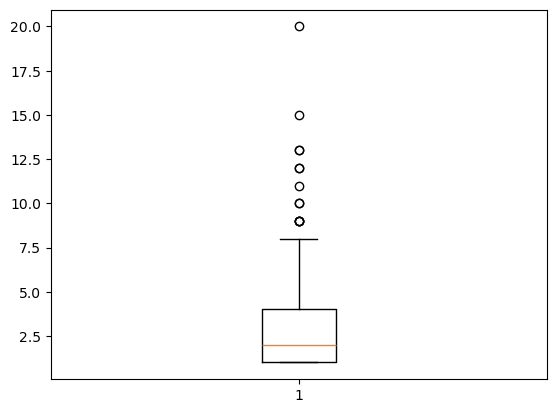

In [32]:
plt.boxplot(SNAP_by_tract.SNAP_count)

In [33]:
LBW.columns

Index(['OBJECTID', 'CT20', 'LABEL', 'ShapeSTArea', 'ShapeSTLength', 'geometry',
       'tract_x', 'census tract', 'Unnamed: 0', 'ignore', 'tract_y',
       'sup_dist', 'csa', 'spa', 'ESRI_OID', 'Shape__Area', 'Shape__Length',
       'Total Woman 15-50', 'Women with births 12 Months', 'Total Population',
       'Birth Rate', 'Fertility Rate', 'Low Birth Weight',
       'Low Birth Weight Pctl', 'Average income', 'Grocery Store Access',
       'Grocery Store Access Percent', 'CalFresh Cases', 'CF cases per 100'],
      dtype='object')

In [35]:
LBW.columns = ['OBJECTID', 'CT20', 'LABEL', 'ShapeSTArea', 'ShapeSTLength', 'geometry',
       'tract_x', 'census_tract', 'Unnamed: 0', 'ignore', 'tract_y',
       'sup_dist', 'csa', 'spa', 'ESRI_OID', 'Shape__Area', 'Shape__Length',
       'Total Woman 15-50', 'Women with births 12 Months', 'Total_Pop',
       'Birth Rate', 'Fertility Rate', 'Low Birth Weight',
       'Low Birth Weight Pctl', 'Average income', 'Grocery Store Access',
       'Grocery Store Access Percent', 'CalFresh Cases', 'CF cases per 100']

In [36]:
LBW = LBW.merge(SNAP_by_tract,on='census_tract')

In [37]:
LBW.sample(10)

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,tract_x,census_tract,Unnamed: 0,ignore,...,Birth Rate,Fertility Rate,Low Birth Weight,Low Birth Weight Pctl,Average income,Grocery Store Access,Grocery Store Access Percent,CalFresh Cases,CF cases per 100,SNAP_count
410,977,269700,2697.00,9.661690e+06,14772.796850,"POLYGON ((-13178331.183 4034151.053, -13178452...",06037269700,06037269700,0,6037269700,...,0.006460,0.025218,6.44,82.76,88214.0,0.0,0.0,158.0,23.0,1
271,663,212202,2122.02,2.222403e+06,6482.090647,"POLYGON ((-13168165.040 4036560.403, -13168164...",06037212202,06037212202,0,6037212202,...,0.008026,0.033962,5.14,56.12,36920.0,0.0,0.0,350.0,57.4,4
310,702,216100,2161.00,7.265854e+06,11195.402908,"POLYGON ((-13172671.699 4036993.744, -13172681...",06037216100,06037216100,0,6037216100,...,0.000000,0.000000,4.85,48.27,120526.0,0.0,0.0,80.0,15.0,1
468,1035,276500,2765.00,1.283049e+07,15367.422770,"POLYGON ((-13181744.684 4023413.992, -13181739...",06037276500,06037276500,0,6037276500,...,0.008029,0.017316,2.59,5.17,101071.0,0.0,0.0,55.0,13.7,4
135,527,197420,1974.20,6.625853e+06,11620.140237,"POLYGON ((-13164572.203 4040747.243, -13164593...",06037197420,06037197420,0,6037197420,...,0.012737,0.032307,5.50,64.47,83400.0,0.0,0.0,224.0,35.1,5
497,2254,701302,7013.02,4.909290e+06,9926.766776,"POLYGON ((-13191368.590 4031892.641, -13191316...",06037701302,06037701302,0,6037701302,...,0.027671,0.089426,6.52,83.85,78542.0,0.0,0.0,163.0,18.4,1
371,938,265204,2652.04,2.855371e+06,7517.683586,"POLYGON ((-13185123.121 4036694.635, -13185108...",06037265204,06037265204,0,6037265204,...,0.000000,0.000000,0.00,0.00,108295.0,0.0,0.0,86.0,47.5,7
132,524,197200,1972.00,8.364430e+06,14833.141771,"POLYGON ((-13162333.457 4041587.511, -13162438...",06037197200,06037197200,0,6037197200,...,0.008214,0.027636,3.30,12.97,62612.0,0.0,0.0,245.0,30.2,1
64,456,189907,1899.07,1.746430e+06,5286.485059,"POLYGON ((-13174611.665 4041493.950, -13174614...",06037189907,06037189907,0,6037189907,...,0.013147,0.040151,0.00,0.00,69489.0,0.0,0.0,234.0,65.5,1
402,969,267901,2679.01,1.205150e+07,15177.397701,"POLYGON ((-13181806.022 4037243.813, -13181733...",06037267901,06037267901,0,6037267901,...,0.003644,0.025974,7.37,92.96,111299.0,0.0,0.0,30.0,4.9,2


In [38]:
LBW['SNAP_per_1000'] = LBW['SNAP_count']/LBW['Total_Pop']*1000

In [40]:
LBW.sort_values(by="SNAP_per_1000").tail()

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,tract_x,census_tract,Unnamed: 0,ignore,...,Fertility Rate,Low Birth Weight,Low Birth Weight Pctl,Average income,Grocery Store Access,Grocery Store Access Percent,CalFresh Cases,CF cases per 100,SNAP_count,SNAP_per_1000
534,2478,980019,9800.19,4.761975e+08,155767.638460,"POLYGON ((-13195202.101 4046322.319, -13195200...",06037980019,06037980019,0,6037980019,...,0.0,0.0,0.00,250001.0,73.0,0.296748,1.0,6.3,1,7.812500
531,2468,980009,9800.09,2.288694e+08,81127.024463,"POLYGON ((-13169579.690 4050151.005, -13169628...",06037980009,06037980009,0,6037980009,...,0.0,0.0,0.00,NaN,0.0,0.000000,1.0,0.0,1,19.230769
536,2494,980038,9800.38,4.861673e+07,42991.767229,"POLYGON ((-13176525.692 4030868.156, -13176524...",06037980038,06037980038,0,6037980038,...,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,1,250.000000
535,2486,980028,9800.28,2.119243e+08,85718.579965,"POLYGON ((-13178640.094 4022802.672, -13178707...",06037980028,06037980028,0,6037980028,...,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,3,272.727273
477,1044,277400,2774.00,6.877749e+06,10438.697565,"POLYGON ((-13177816.218 4022445.693, -13177823...",06037277400,06037277400,0,6037277400,...,NaN,10.0,99.51,34318.0,647.0,0.422048,3.0,2.5,2,666.666667


In [46]:
LBW.sort_values(by="Total_Pop").tail()

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,tract_x,census_tract,Unnamed: 0,ignore,...,Fertility Rate,Low Birth Weight,Low Birth Weight Pctl,Average income,Grocery Store Access,Grocery Store Access Percent,CalFresh Cases,CF cases per 100,SNAP_count,SNAP_per_1000
523,2280,703002,7030.02,3.527085e+07,27859.362899,"POLYGON ((-13176391.663 4028501.769, -13176378...",06037703002,06037703002,0,6037703002,...,0.007869,4.87,48.77,101264.0,617.0,0.092964,226.0,13.1,3,0.434342
215,607,207902,2079.02,7.532287e+06,11167.818144,"POLYGON ((-13164236.463 4033589.936, -13164101...",06037207902,06037207902,0,6037207902,...,0.033510,0.00,0.00,106206.0,0.0,0.000000,279.0,36.3,4,0.540176
462,1029,275604,2756.04,1.668909e+07,25536.539830,"POLYGON ((-13180180.645 4026600.903, -13180218...",06037275604,06037275604,0,6037275604,...,0.068323,0.00,0.00,173569.0,0.0,0.000000,102.0,4.3,3,0.285171
522,2279,702900,7029.00,4.043091e+07,25965.913567,"POLYGON ((-13183970.629 4025345.738, -13183965...",06037702900,06037702900,0,6037702900,...,0.053634,0.00,0.00,120437.0,137.0,0.015484,309.0,16.1,3,0.263783
372,939,265301,2653.01,1.717677e+07,20495.487120,"POLYGON ((-13184428.710 4038711.686, -13184448...",06037265301,06037265301,0,6037265301,...,0.000000,0.00,0.00,NaN,0.0,0.000000,144.0,0.0,3,0.221779


In [52]:
LBW = LBW.astype({"Total_Pop":int})

In [57]:
LBW3= LBW.query('Total_Pop > 20')

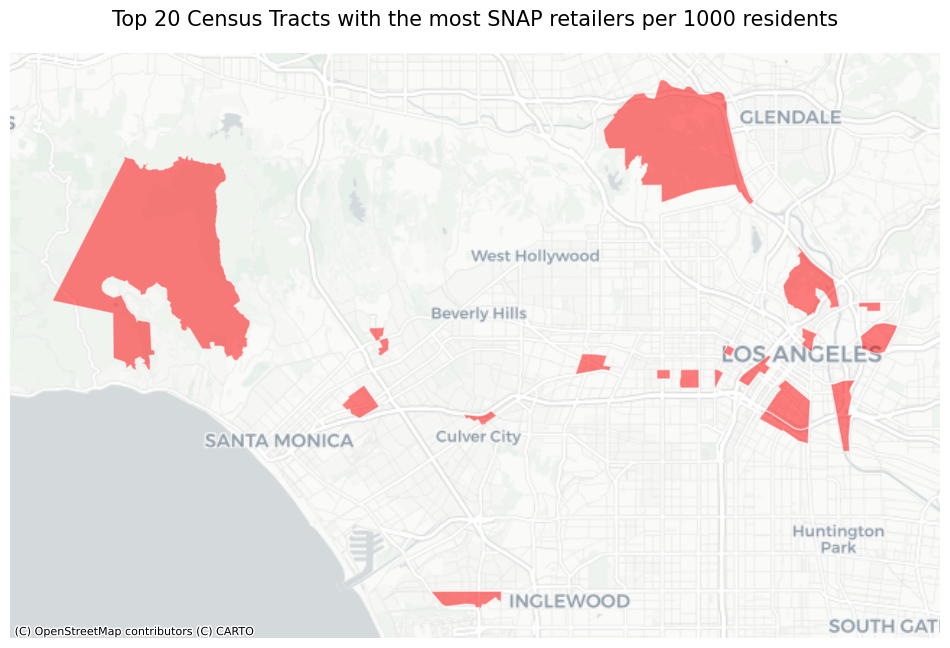

In [58]:
# map the top 20 geographies
fig,ax = plt.subplots(figsize=(12,10))
LBW3.sort_values(by='SNAP_per_1000',ascending=False)[:20].plot(ax=ax,
                                                                 color='red',
                                                                 edgecolor='white',
                                                                 alpha=0.5)

# title
ax.set_title('Top 20 Census Tracts with the most SNAP retailers per 1000 residents',fontsize=15,pad=20)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [61]:
wq =  lps.weights.KNN.from_dataframe(LBW3,k=4)

In [62]:
wq.transform = 'r'

In [63]:
LBW3['SNAP_per_1000_lag'] = lps.weights.lag_spatial(wq, LBW3['SNAP_per_1000'])

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [64]:
LBW3.sample(10)[['census_tract','Total_Pop','SNAP_count','SNAP_per_1000','SNAP_per_1000_lag']]

,census_tract,Total_Pop,SNAP_count,SNAP_per_1000,SNAP_per_1000_lag
449,06037273800,2933,1,0.340948,0.632565
205,06037207305,1181,3,2.540220,1.222596
86,06037191204,1862,3,1.611171,1.537889
490,06037700801,4941,4,0.809553,0.394798
335,06037221302,4330,8,1.847575,1.250098
375,06037265306,2081,1,0.480538,1.686075
491,06037700802,3892,1,0.256937,0.681489
248,06037211000,5268,8,1.518603,0.501820
337,06037221304,3032,1,0.329815,1.771308
264,06037211803,3602,1,0.277624,0.688429


In [67]:
LBW3['SNAP_count_lag_diff'] = LBW3['SNAP_per_1000'] - LBW3['SNAP_per_1000_lag']

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [68]:
LBW3.sort_values(by='SNAP_count_lag_diff')

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,tract_x,census_tract,Unnamed: 0,ignore,...,Average income,Grocery Store Access,Grocery Store Access Percent,CalFresh Cases,CF cases per 100,SNAP_count,SNAP_per_1000,SNAP_per_1000_lag,SNAP_count_lag,SNAP_count_lag_diff
191,583,206051,2060.51,4.015774e+07,30027.529715,"POLYGON ((-13161437.780 4034377.954, -13161455...",06037206051,06037206051,0,6037206051,...,119453.0,6.0,0.002574,83.0,34.2,3,1.157854,4.033641,-2.875787,-2.875787
379,946,265521,2655.21,1.409937e+06,5592.735680,"POLYGON ((-13185068.129 4036095.232, -13185153...",06037265521,06037265521,0,6037265521,...,51014.0,0.0,0.000000,158.0,54.9,1,0.513347,2.788477,-2.275130,-2.275130
370,937,265203,2652.03,3.337200e+06,8484.000961,"POLYGON ((-13184124.696 4037472.656, -13184126...",06037265203,06037265203,0,6037265203,...,56656.0,0.0,0.000000,92.0,22.0,1,0.448833,2.631422,-2.182589,-2.182589
132,524,197200,1972.00,8.364430e+06,14833.141771,"POLYGON ((-13162333.457 4041587.511, -13162438...",06037197200,06037197200,0,6037197200,...,62612.0,0.0,0.000000,245.0,30.2,1,0.304229,2.377190,-2.072961,-2.072961
133,525,197300,1973.00,7.042091e+06,15215.654315,"POLYGON ((-13163599.048 4039765.776, -13163598...",06037197300,06037197300,0,6037197300,...,86326.0,0.0,0.000000,241.0,32.2,2,0.547945,2.540565,-1.992620,-1.992620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,604,207711,2077.11,7.469515e+06,14744.237737,"POLYGON ((-13164565.635 4035017.571, -13164535...",06037207711,06037207711,0,6037207711,...,121477.0,0.0,0.000000,95.0,37.4,10,4.385965,0.631321,3.754644,3.754644
371,938,265204,2652.04,2.855371e+06,7517.683586,"POLYGON ((-13185123.121 4036694.635, -13185108...",06037265204,06037265204,0,6037265204,...,108295.0,0.0,0.000000,86.0,47.5,7,5.922166,0.439049,5.483116,5.483116
532,2469,980010,9800.10,4.126462e+07,36580.178340,"POLYGON ((-13160979.700 4039666.452, -13160996...",06037980010,06037980010,0,6037980010,...,31875.0,0.0,0.000000,21.0,77.8,1,6.944444,0.417733,6.526711,6.526711
534,2478,980019,9800.19,4.761975e+08,155767.638460,"POLYGON ((-13195202.101 4046322.319, -13195200...",06037980019,06037980019,0,6037980019,...,250001.0,73.0,0.296748,1.0,6.3,1,7.812500,0.250901,7.561599,7.561599


In [69]:
LBW3_donut = LBW3.sort_values(by='SNAP_count_lag_diff').head(1)
LBW3_donut

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,tract_x,census_tract,Unnamed: 0,ignore,...,Average income,Grocery Store Access,Grocery Store Access Percent,CalFresh Cases,CF cases per 100,SNAP_count,SNAP_per_1000,SNAP_per_1000_lag,SNAP_count_lag,SNAP_count_lag_diff
191,583,206051,2060.51,4.015774e+07,30027.529715,"POLYGON ((-13161437.780 4034377.954, -13161455...",06037206051,06037206051,0,6037206051,...,119453.0,6.0,0.002574,83.0,34.2,3,1.157854,4.033641,-2.875787,-2.875787


In [71]:
LBW3_diamond= LBW3.sort_values(by='SNAP_count_lag_diff').tail(1)
LBW3_diamond

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,tract_x,census_tract,Unnamed: 0,ignore,...,Average income,Grocery Store Access,Grocery Store Access Percent,CalFresh Cases,CF cases per 100,SNAP_count,SNAP_per_1000,SNAP_per_1000_lag,SNAP_count_lag,SNAP_count_lag_diff
531,2468,980009,9800.09,2.288694e+08,81127.024463,"POLYGON ((-13169579.690 4050151.005, -13169628...",06037980009,06037980009,0,6037980009,...,NaN,0.0,0.0,1.0,0.0,1,19.230769,0.483457,18.747313,18.747313


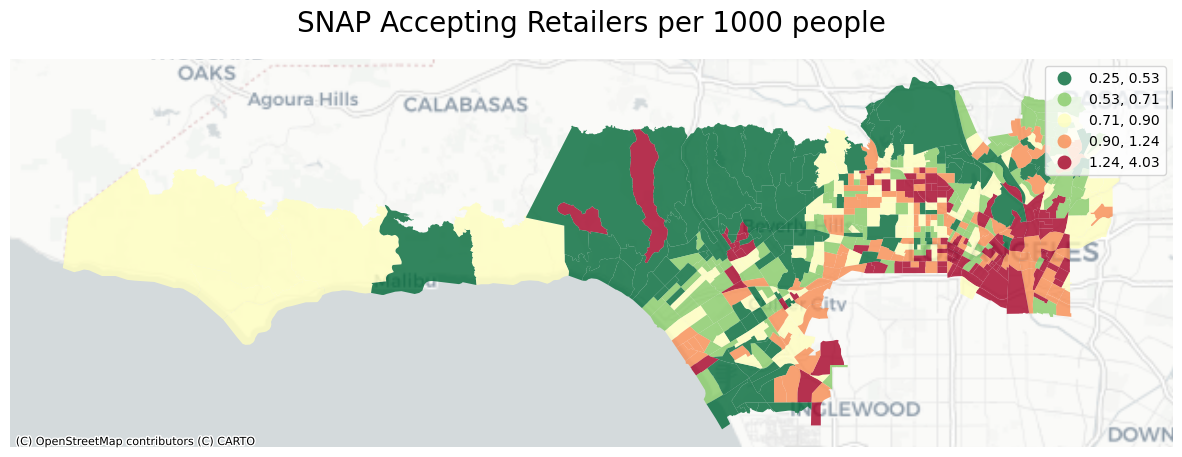

In [72]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(15, 15))

# spatial lag choropleth
LBW3.plot(ax=ax,
         figsize=(15,15),
         column='SNAP_per_1000_lag',
         legend=True,
         alpha=0.8,
         cmap='RdYlGn_r',
         scheme='quantiles')

ax.axis('off')
ax.set_title('SNAP Accepting Retailers per 1000 people',fontsize=20,pad=20)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [73]:
y = LBW3.SNAP_per_1000
moran = Moran(y, wq)
moran.I

0.02943294104298981

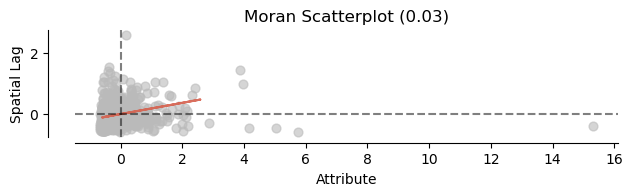

In [74]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

/opt/conda/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.03', ylabel='Density'>)

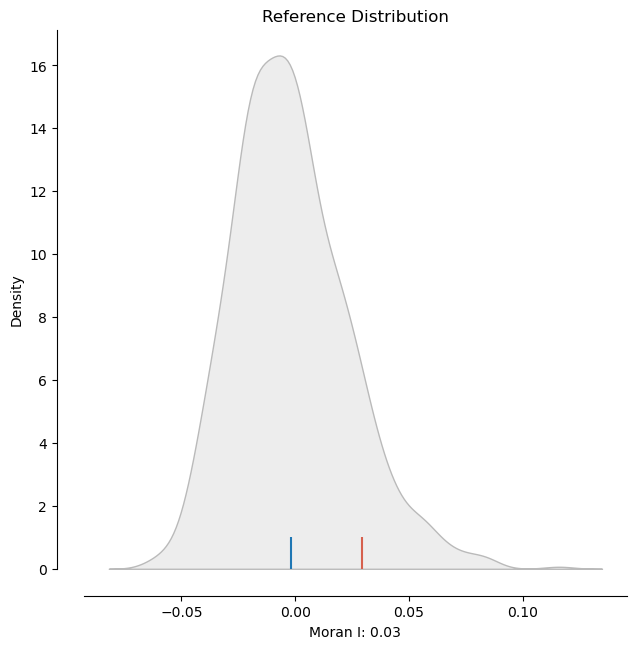

In [75]:
plot_moran_simulation(moran,aspect_equal=False)

In [76]:
moran.p_sim

0.108

In [77]:
lisa = esda.moran.Moran_Local(y, wq)

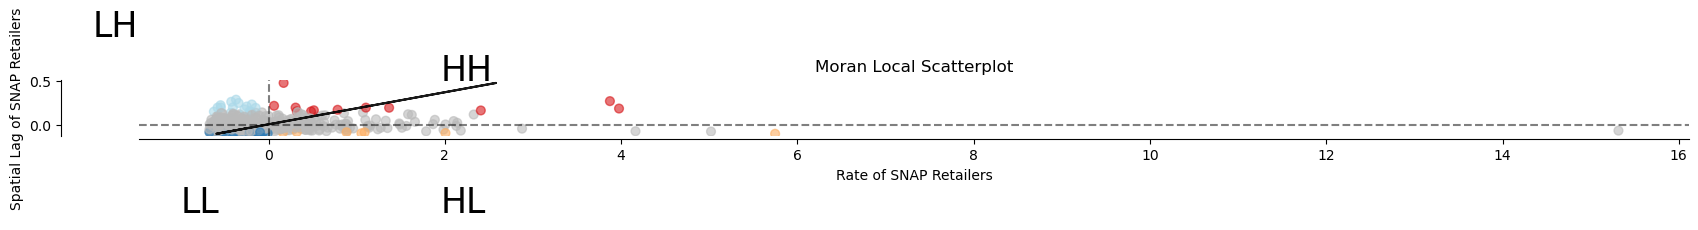

In [82]:
fig,ax = plt.subplots(figsize=(20,20))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Rate of SNAP Retailers")
ax.set_ylabel('Spatial Lag of SNAP Retailers')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

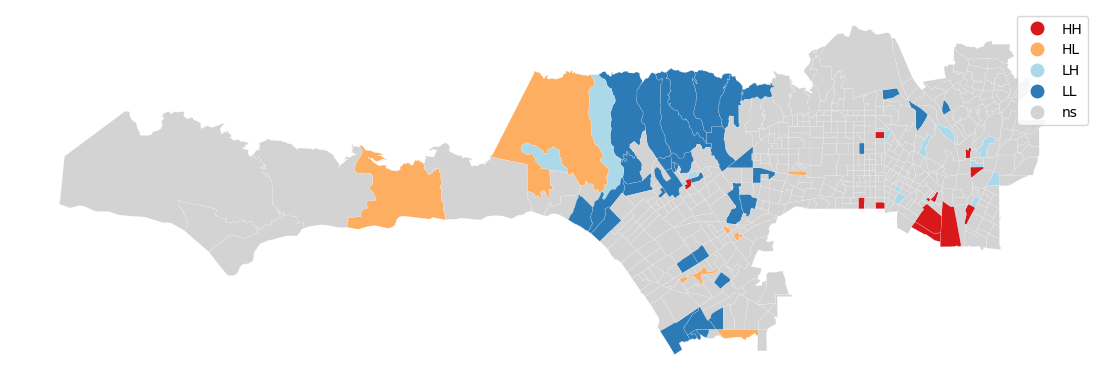

In [83]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, LBW3, p=0.05, ax=ax)
plt.show()